In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !unzip '/content/drive/MyDrive/Capstone/dataset.zip' -d '/content/drive/MyDrive/Capstone/Dataset'

Archive:  /content/drive/MyDrive/Capstone/dataset.zip
  inflating: /content/drive/MyDrive/Capstone/Dataset/classname.txt  
  inflating: /content/drive/MyDrive/Capstone/Dataset/train.csv  
  inflating: /content/drive/MyDrive/Capstone/Dataset/train/angular_leaf_spot/angular_leaf_spot_train.0.jpg  
  inflating: /content/drive/MyDrive/Capstone/Dataset/train/angular_leaf_spot/angular_leaf_spot_train.1.jpg  
  inflating: /content/drive/MyDrive/Capstone/Dataset/train/angular_leaf_spot/angular_leaf_spot_train.10.jpg  
  inflating: /content/drive/MyDrive/Capstone/Dataset/train/angular_leaf_spot/angular_leaf_spot_train.100.jpg  
  inflating: /content/drive/MyDrive/Capstone/Dataset/train/angular_leaf_spot/angular_leaf_spot_train.101.jpg  
  inflating: /content/drive/MyDrive/Capstone/Dataset/train/angular_leaf_spot/angular_leaf_spot_train.102.jpg  
  inflating: /content/drive/MyDrive/Capstone/Dataset/train/angular_leaf_spot/angular_leaf_spot_train.103.jpg  
  inflating: /content/drive/MyDrive/Caps

# Import Library

In [2]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import keras

# Data Preprocessing

In [3]:
TRAIN_DIR = "/content/drive/MyDrive/Capstone/Dataset/train"
VALIDATION_DIR = "/content/drive/MyDrive/Capstone/Dataset/val"

BATCH_SIZE = 32
IMAGE_SIZE =(224,224)
EPOCHS = 100

## Class Distribution
Getting the class distribution to look at class imbalance

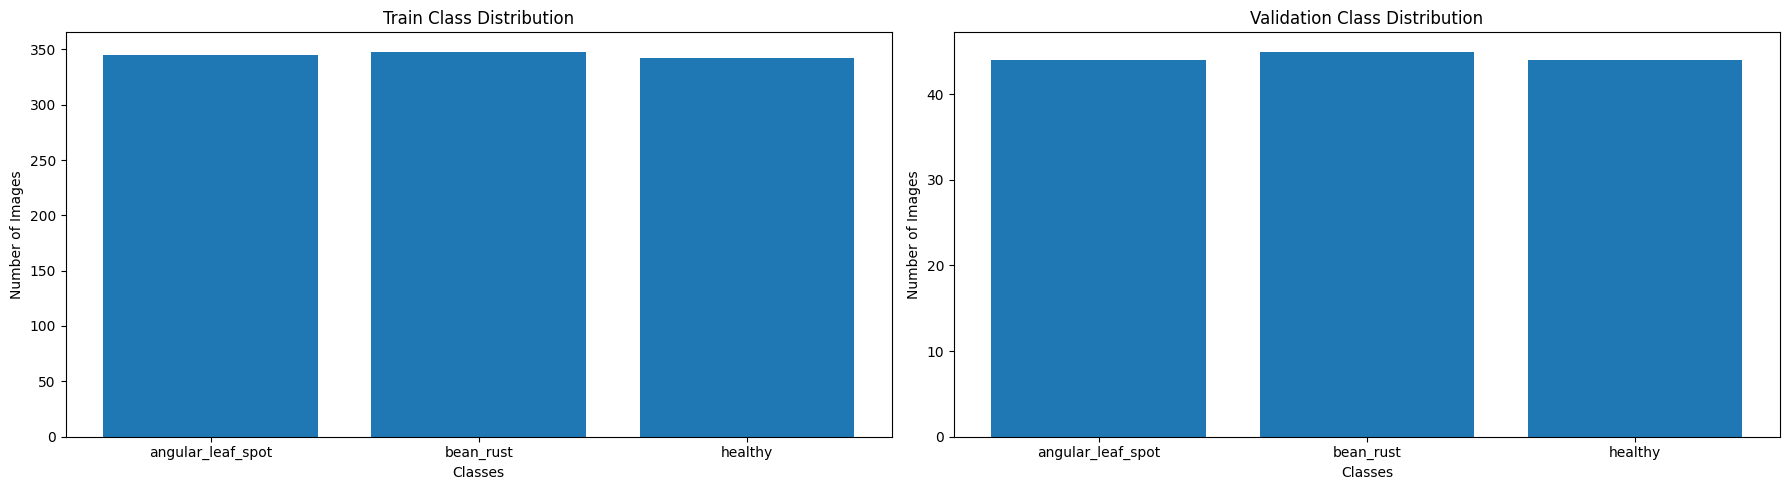

In [4]:
import os
import matplotlib.pyplot as plt

train_path = TRAIN_DIR
validation_path = VALIDATION_DIR

def count_images_in_folders(path):
    class_counts = {}
    for class_folder in os.listdir(path):
        class_path = os.path.join(path, class_folder)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            class_counts[class_folder] = num_images
    return class_counts

train_counts = count_images_in_folders(train_path)
validation_counts = count_images_in_folders(validation_path)

fig, ax = plt.subplots(1, 2, figsize=(18, 5))

ax[0].bar(train_counts.keys(), train_counts.values())
ax[0].set_title('Train Class Distribution')
ax[0].set_xlabel('Classes')
ax[0].set_ylabel('Number of Images')

ax[1].bar(validation_counts.keys(), validation_counts.values())
ax[1].set_title('Validation Class Distribution')
ax[1].set_xlabel('Classes')
ax[1].set_ylabel('Number of Images')

plt.tight_layout()
plt.show()


## Data splitting

In [5]:
train_dataset, validation_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=TRAIN_DIR,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    color_mode = "rgb",
    validation_split=0.2,
    subset="both",
    seed=0
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=VALIDATION_DIR,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    label_mode="categorical",
    color_mode = "rgb"
)

Found 1034 files belonging to 3 classes.
Using 828 files for training.
Using 206 files for validation.
Found 133 files belonging to 3 classes.


## Image Augmentation

In [6]:
augmentation_layers = tf.keras.Sequential([
    tf.keras.Input(shape=(224, 224, 3)),
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(0.2),
])


In [7]:
train_dataset = train_dataset.map(lambda x, y: (augmentation_layers(x, training=True), y))

# Model Development

## Model building
The base model for this project is VGG16. This model were chosen because of it's simplicity in model architecture.

We also fine-tuned the model by adding our own fully connected layer on top of this base model.

Although the model size will be large, this will not be a problem for the app because the model will be hosted in a cloud.

In [9]:
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights = "imagenet",
    input_shape=(224, 224, 3)
)

base_model.trainable = True

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [10]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(224,224,3)),
    tf.keras.layers.Rescaling(1./255),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(units=2042,activation= "relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units=2042,activation= "relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units=2042,activation= "relu"),
    tf.keras.layers.Dense(units=3,activation= "softmax"),
])


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics= ['accuracy', keras.metrics.Precision(name="precision"), keras.metrics.Recall(name="recall"), keras.metrics.F1Score(average='macro', threshold=0.5, name="f1_score")],
)

In [11]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2042)                │       1,047,546 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2042)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2042)                │       4,171,806 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 2042)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2042)                │       4,171,806 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │           6,129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,111,975 (91.98 MB)

 Trainable params: 24,111,975 (91.98 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training
The model trained with the defined hyperparameter and also use early stopping callback to prevent overfitting

In [12]:
earlyStopping = tf.keras.callbacks.EarlyStopping( monitor="val_loss", patience=10,
                                         verbose=1,  restore_best_weights=True)

In [13]:
model_history = model.fit(
	train_dataset,
	epochs=EPOCHS,
	validation_data=validation_dataset,
	callbacks = [earlyStopping]
)

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 473s 17s/step - accuracy: 0.3223 - f1_score: 0.0541 - loss: 1.1347 - precision: 0.2392 - recall: 0.0376 - val_accuracy: 0.2816 - val_f1_score: 0.0000e+00 - val_loss: 1.0987 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 23s 860ms/step - accuracy: 0.3322 - f1_score: 0.0000e+00 - loss: 1.0984 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2961 - val_f1_score: 0.0000e+00 - val_loss: 1.0989 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 25s 953ms/step - accuracy: 0.3572 - f1_score: 0.0000e+00 - loss: 1.0974 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2961 - val_f1_score: 0.0000e+00 - val_loss: 1.0907 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 40s 921ms/step - accuracy: 0.3848 - f1_score: 0.0520 - loss: 1.0633 - precision: 0.3086 - recall: 0.0366 - val_accuracy: 0.4709 - val_f1_sco

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.9716 - f1_score: 0.9704 - loss: 0.0971 - precision: 0.9716 - recall: 0.9716

Val Accuracy: 0.9708737730979919
Val Precision: 0.9708737730979919
Val Recall: 0.9708737730979919
Val F1 Score: 0.9699274897575378


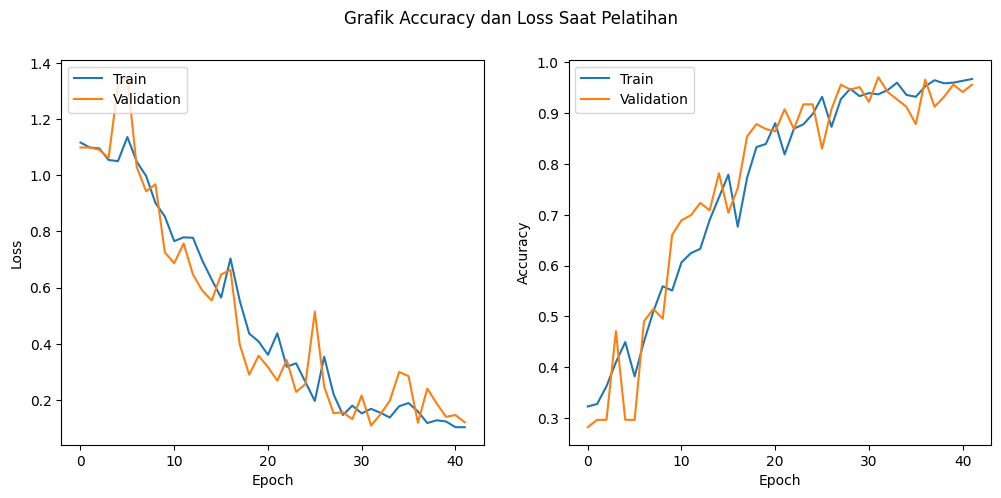

In [14]:
scores_val = model.evaluate(validation_dataset)

print("")
print(f"Val Accuracy: {scores_val[1]}")
print(f"Val Precision: {scores_val[2]}")
print(f"Val Recall: {scores_val[3]}")
print(f"Val F1 Score: {scores_val[4]}")

plt.figure(figsize=(12, 5))
plt.suptitle('Grafik Accuracy dan Loss Saat Pelatihan')

plt.subplot(1, 2, 1)
plt.plot(model_history.history['loss'], label='loss')
plt.plot(model_history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(model_history.history['accuracy'], label='accuracy')
plt.plot(model_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

The model can achieve ~97% accuracy and not overfit on validation data

In [15]:
scores = model.evaluate(test_dataset)
print(f"Accuracy: {scores[1]}")
print(f"Precision: {scores[2]}")
print(f"Recall: {scores[3]}")
print(f"F1 Score: {scores[4]}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 57s 11s/step - accuracy: 0.9756 - f1_score: 0.9757 - loss: 0.0834 - precision: 0.9756 - recall: 0.9756
Accuracy: 0.9774436354637146
Precision: 0.9774436354637146
Recall: 0.9774436354637146
F1 Score: 0.9776638150215149


The test result performance also confirmed the model is not overfit and can achieve good performance

# Model Export

## Model exported to SavedModel format

In [16]:
EXPORT_DIR = "/content/drive/MyDrive/Capstone/Models/23_Nov_2nd"
tf.saved_model.save(model, EXPORT_DIR)

In [17]:
!pip install tensorflowjs

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 96.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 60.9 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully unin

## Model exported to tensorflow.js format

In [18]:
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --output_format=tfjs_graph_model \
    /content/drive/MyDrive/Capstone/Models/23_Nov_2nd\
    /content/drive/MyDrive/Capstone/JS_Models/23_Nov_2nd_TFJS

2024-11-23 07:25:53.294181: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732346753.315484   10786 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732346753.321775   10786 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2024-11-23 07:25:58.248401: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1732346758.248605   10786 gpu_device.cc:2022] Created device /job:localhost/replica:0/task